In [1]:
import datetime
import string

import nltk
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

In [2]:
spec_chars = string.punctuation + '\n\xa0«»\t—…–'


def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])


def join_all_titles(data):
    res = ''
    for i in range(len(data)):
        row = data.iloc[i]
        if type(row['title']) != str:
            continue
        res += '\n' + row['title']
    return res


def compute_frequent_words(data):
    text = join_all_titles(data)
    text = remove_chars_from_text(text, spec_chars)
    tokens = word_tokenize(text)
    freq_dict = FreqDist(nltk.Text([token.strip() for token in tokens if token not in russian_stopwords]))
    return freq_dict


def group_by(data, column: str):
    grouped = data.groupby(column)
    grouped_res = pd.DataFrame([], columns=[column, 'count', 'views', 'likes', 'comments', 'favorites', 'hits'])
    grouped_res[column] = grouped[column].first()
    grouped_res['count'] = grouped[column].count()
    grouped_res['views'] = grouped['views'].sum()
    grouped_res['likes'] = grouped['likes'].sum()
    grouped_res['comments'] = grouped['comments'].sum()
    grouped_res['favorites'] = grouped['favorites'].sum()
    grouped_res['hits'] = grouped['hits'].sum()
    grouped_res['avg_views'] = grouped_res['views'] / grouped_res['count']
    return grouped_res

In [3]:
data = pd.read_csv('./vc_posts.csv')
data = data[(data['title'].notnull()) & (data['is_advertisement'] == False)]
data['tags'] = data['tags'].apply(eval)
data['tags_count'] = data['tags'].apply(len)
data['title_len'] = data['title'].apply(len)
data['content_len'] = data['content'].apply(len)
data['date'] = data['date'].apply(datetime.datetime.strptime, args=('%a, %d %b %Y %H:%M:%S %z',))
data['days_since_post'] = data['date'].apply(lambda x: (datetime.datetime.now(datetime.timezone.utc) - x).days)
data['images_count'] = data['content'].apply(lambda x: x.count('<img'))
grouped_by_author = group_by(data, 'author_name')
data['author_total_views'] = data['author_name'].apply(
    lambda x: grouped_by_author[grouped_by_author['author_name'] == x]['views'].values[0])
data['author_total_posts'] = data['author_name'].apply(
    lambda x: grouped_by_author[grouped_by_author['author_name'] == x]['count'].values[0])
data.head()

,_id,author_name,author_type,comments,content,createdAt,date,favorites,hits,id,...,title,url,views,tags_count,title_len,content_len,days_since_post,images_count,author_total_views,author_total_posts
0,6616c4acd2ad343afb59d936,Успешный провал,self,2,"<div class=""l-island-a"">\n \n <p>Отк...",2024-04-10T16:56:12.412Z,2024-04-09 18:42:14+03:00,0,372,1118037,...,Как потерять бизнес за три месяца,https://vc.ru/life/1118037-kak-poteryat-biznes...,2644,0,33,17238,1,1,5478,3
1,6616c4acd2ad343afb59d935,Realm Digital,self,2,"<figure class=""figure-image"">\n <style>\n ...",2024-04-10T16:56:12.060Z,2024-04-08 17:01:57+03:00,1,64,1115687,...,Зачем Вашему Бизнесу Профессиональный Веб-Сайт?,https://vc.ru/life/1115687-zachem-vashemu-bizn...,790,0,47,7480,2,1,790,1
2,6616c4abd2ad343afb59d934,Таня Боброва,editor,102,"<div class=""l-island-a"">\n \n <p>Ком...",2024-04-10T16:56:11.889Z,2024-04-09 13:19:04+03:00,9,4649,1117264,...,Отчёт Ozon за год: выручка выросла на 53% — до...,https://vc.ru/money/1117264-otchet-ozon-za-god...,16068,3,141,4870,1,0,1698894,964
3,6616c4abd2ad343afb59d933,Pyrobyte,self,17,"<div class=""l-island-a"">\n \n <p>При...",2024-04-10T16:56:11.606Z,2024-04-09 07:47:32+03:00,31,903,1110527,...,8 лучших сервисов для автоматизации транспортн...,https://vc.ru/transport/1110527-8-luchshih-ser...,10583,0,70,50264,1,2,74494,7
4,6616c4abd2ad343afb59d932,Timur Taepov,self,0,"<div class=""l-island-a"">\n \n <p>Это...",2024-04-10T16:56:11.119Z,2024-04-09 19:28:03+03:00,2,47,1118101,...,Как создать AI-продукт новичку? Базовые поняти...,https://vc.ru/chatgpt/1118101-kak-sozdat-ai-pr...,501,0,61,7340,1,0,1398,2


# Data grouped by topic and sorted by average views

In [4]:
grouped_subsite = group_by(data, 'subsite_label')
grouped_subsite.sort_values(by='avg_views', ascending=False).head(10)

,subsite_label,count,views,likes,comments,favorites,hits,avg_views
subsite_label,,,,,,,,
molyanov,molyanov,2,53163,280,275,292,29646,26581.500000
ratingruneta,ratingruneta,3,55506,263,345,101,9971,18502.000000
ya-specialist,ya-specialist,3,52133,153,283,38,6895,17377.666667
finder,finder,3,49653,166,266,107,20003,16551.000000
awake_journal_ru,awake_journal_ru,1,14187,42,119,11,2637,14187.000000
igotosochi,igotosochi,32,395863,414,1149,363,81685,12370.718750
begovatovd,begovatovd,22,268295,1034,1330,891,77612,12195.227273
volts,volts,1,9461,42,37,24,2813,9461.000000
nikanorova,nikanorova,4,37594,297,338,477,191253,9398.500000


# Data grouped by topic and sorted by total views

In [5]:
grouped_subsite.sort_values(by='views', ascending=False).head(10)

,subsite_label,count,views,likes,comments,favorites,hits,avg_views
subsite_label,,,,,,,,
marketing,marketing,2880,3488988,51466,36184,113948,16358339,1211.454167
unknown,unknown,10759,3471474,22200,24525,17312,9202893,322.657682
money,money,1881,2708191,45658,81311,56165,16377092,1439.761297
life,life,1079,2025319,34246,30104,55272,9619967,1877.033364
services,services,1160,1338297,32392,40936,47476,13940915,1153.704310
legal,legal,733,1030489,16366,32095,14265,6003769,1405.851296
trade,trade,736,1016924,18944,31079,23705,6860712,1381.690217
claim,claim,1009,952317,19969,40432,3972,5415358,943.822597
design,design,648,813164,20621,16046,38238,5146462,1254.882716


In [6]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['это'])

# Most common words among all articles

In [7]:
compute_frequent_words(data).most_common(20)

[('Статьи', 4418),
 ('России', 610),
 ('Как', 535),
 ('млн', 525),
 ('редакцииКак', 518),
 ('рублей', 430),
 ('которые', 368),
 ('сервис', 337),
 ('компании', 335),
 ('года', 316),
 ('бизнес', 276),
 ('помощью', 271),
 ('2023', 266),
 ('млрд', 263),
 ('бизнеса', 262),
 ('изза', 260),
 ('почему', 258),
 ('1', 250),
 ('деньги', 246),
 ('Google', 240)]

# Most common articles amoung articles with over 10K views


In [8]:
compute_frequent_words(data[data['views'] > 10_000]).most_common(20)

[('Статьи', 220),
 ('года', 35),
 ('России', 34),
 ('2023', 33),
 ('рублей', 32),
 ('редакцииКак', 27),
 ('млн', 24),
 ('которые', 18),
 ('10', 17),
 ('году', 16),
 ('тысяч', 16),
 ('Как', 15),
 ('млрд', 14),
 ('2024', 13),
 ('компании', 12),
 ('Telegram', 12),
 ('бизнес', 11),
 ('коротко', 11),
 ('1', 11),
 ('редакцииДень', 11)]

# Correlation matrix

In [9]:
cormat = data[
    ['views', 'tags_count', 'favorites', 'likes', 'comments', 'hits', 'title_len', 'content_len', 'images_count',
     'days_since_post', 'author_total_posts', 'author_total_views']].corr()
cormat

,views,tags_count,favorites,likes,comments,hits,title_len,content_len,images_count,days_since_post,author_total_posts,author_total_views
views,1.000000,0.009889,0.030058,0.134470,0.282145,0.010243,0.080177,0.058783,-0.042740,-0.180404,0.021843,0.142790
tags_count,0.009889,1.000000,0.016304,0.082803,0.126015,0.072138,0.214828,-0.007054,0.066729,0.098817,0.250841,0.176466
favorites,0.030058,0.016304,1.000000,0.604590,0.267797,0.481472,0.091523,0.334574,0.151672,0.269057,-0.002951,-0.000824
likes,0.134470,0.082803,0.604590,1.000000,0.591520,0.617801,0.205058,0.241475,0.162056,0.316150,0.127847,0.083083
comments,0.282145,0.126015,0.267797,0.591520,1.000000,0.322686,0.291362,0.053800,0.075068,0.146000,0.252115,0.276131
hits,0.010243,0.072138,0.481472,0.617801,0.322686,1.000000,0.120958,0.187575,0.112420,0.240919,0.069722,0.039954
title_len,0.080177,0.214828,0.091523,0.205058,0.291362,0.120958,1.000000,0.054561,0.114014,0.264272,0.505829,0.388285
content_len,0.058783,-0.007054,0.334574,0.241475,0.053800,0.187575,0.054561,1.000000,0.229771,0.171722,-0.150349,-0.113774
images_count,-0.042740,0.066729,0.151672,0.162056,0.075068,0.112420,0.114014,0.229771,1.000000,0.378421,0.118143,0.034130
days_since_post,-0.180404,0.098817,0.269057,0.316150,0.146000,0.240919,0.264272,0.171722,0.378421,1.000000,0.303957,0.095118


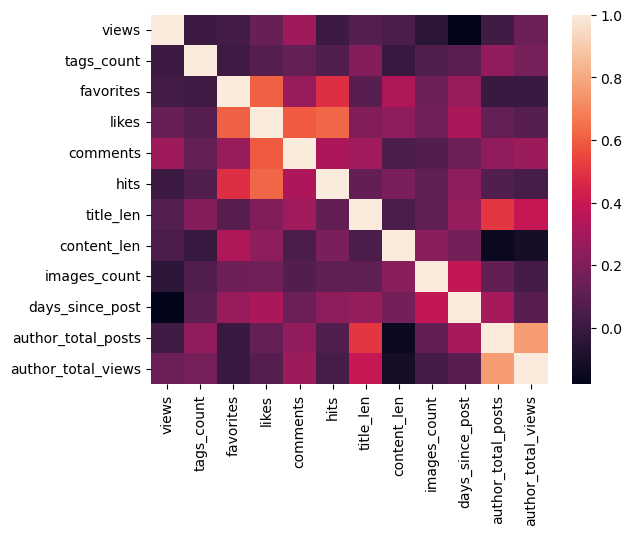

In [10]:
sns.heatmap(cormat);

## Conclusions:
- VC promotes posts with more likes and comments (likes & comments are more correlated with hits than views)
- There is correlation between content length and likes + favorites
- There is a weak correlation between title length and likes + comments

# Scatter plots

Text(0.5, 0, 'Hits')

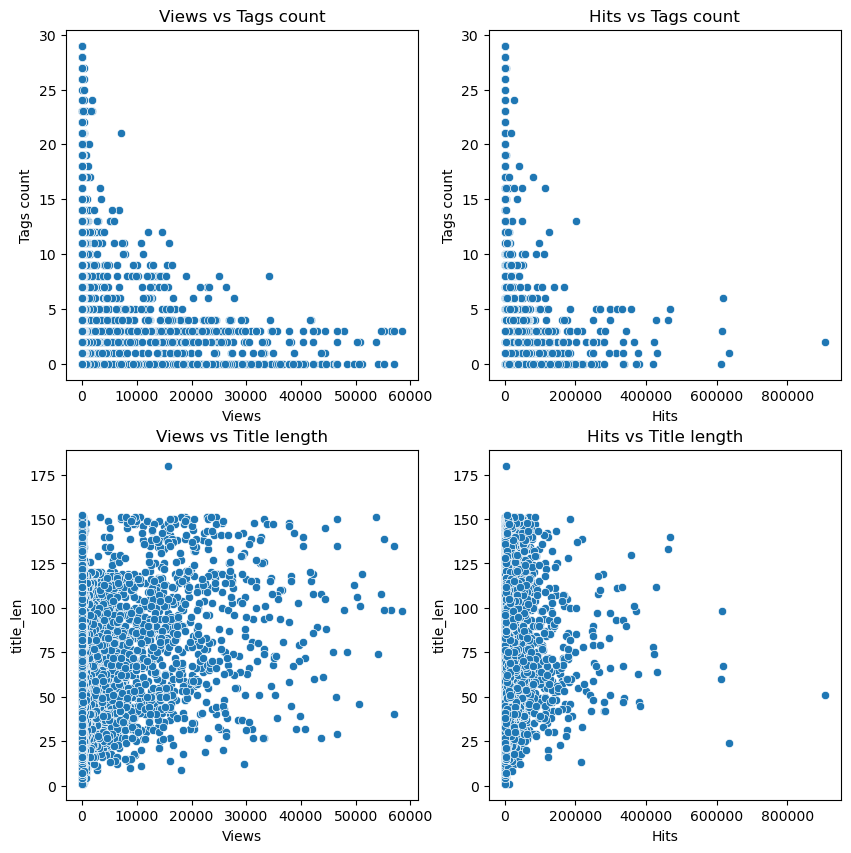

In [11]:
# create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

_data = data[(data['views'] < 60_000) & (data['tags_count'] < 30)]
ax = sns.scatterplot(x="views", y="tags_count", data=_data, ax=axs[0, 0])
ax.set_title('Views vs Tags count')
ax.set_xlabel('Views')
ax.set_ylabel('Tags count')

_data = data[(data['hits'] < 1_000_000) & (data['tags_count'] < 30)]
ax = sns.scatterplot(x="hits", y="tags_count", data=_data, ax=axs[0, 1])
ax.set_title('Hits vs Tags count')
ax.set_xlabel('Hits')
ax.set_ylabel('Tags count')

_data = data[(data['views'] < 60_000)]
ax = sns.scatterplot(x="views", y="title_len", data=_data, ax=axs[1, 0])
ax.set_title('Views vs Title length')
ax.set_xlabel('Views')

_data = data[(data['hits'] < 1_000_000)]
ax = sns.scatterplot(x="hits", y="title_len", data=_data, ax=axs[1, 1])
ax.set_title('Hits vs Title length')
ax.set_xlabel('Hits')

Text(0, 0.5, 'Content length')

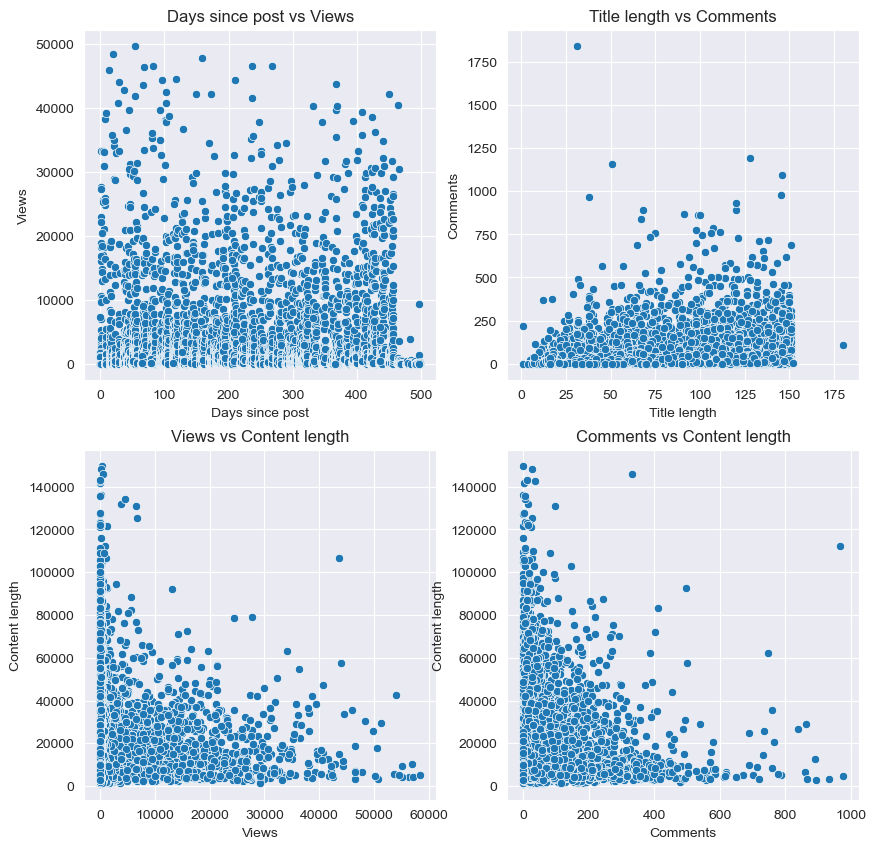

In [17]:
# create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
_data = data[(data['views'] < 50_000) & (data['days_since_post'] < 500)]
ax = sns.scatterplot(x="days_since_post", y="views", data=_data, ax=axs[0, 0])
ax.set_title('Days since post vs Views')
ax.set_xlabel('Days since post')
ax.set_ylabel('Views')

ax = sns.scatterplot(x="title_len", y="comments", data=data, ax=axs[0, 1])
ax.set_title('Title length vs Comments')
ax.set_xlabel('Title length')
ax.set_ylabel('Comments')

_data = data[(data['content_len'] < 150_000) & (data['views'] < 60_000)]
ax = sns.scatterplot(x="views", y="content_len", data=_data, ax=axs[1, 0])
ax.set_title('Views vs Content length')
ax.set_xlabel('Views')
ax.set_ylabel('Content length')

_data = data[(data['content_len'] < 150_000) & (data['comments'] < 1000)]
ax = sns.scatterplot(x="comments", y="content_len", data=_data, ax=axs[1, 1])
ax.set_title('Comments vs Content length')
ax.set_xlabel('Comments')
ax.set_ylabel('Content length')


Text(0, 0.5, 'Author total posts')

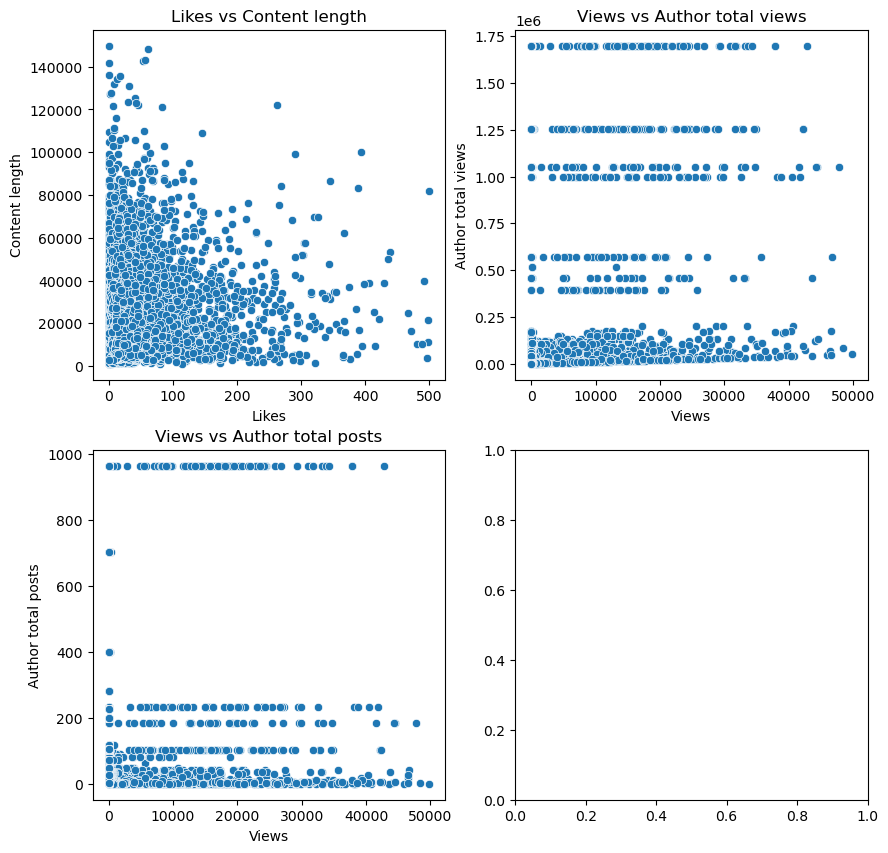

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

_data = data[(data['content_len'] < 150_000) & (data['likes'] < 500)]
ax = sns.scatterplot(x="likes", y="content_len", data=_data, ax=axs[0, 0])
ax.set_title('Likes vs Content length')
ax.set_xlabel('Likes')
ax.set_ylabel('Content length')

_data = data[(data['views'] < 50_000) & (data['author_total_views'] < 5_000_000)]
ax = sns.scatterplot(x="views", y="author_total_views", data=_data, ax=axs[0, 1])
ax.set_title('Views vs Author total views')
ax.set_xlabel('Views')
ax.set_ylabel('Author total views')

_data = data[(data['views'] < 50_000) & (data['author_total_posts'] < 1000)]
ax = sns.scatterplot(x="views", y="author_total_posts", data=_data, ax=axs[1, 0])
ax.set_title('Views vs Author total posts')
ax.set_xlabel('Views')
ax.set_ylabel('Author total posts')